# Coupling rainfall-runoff-soil infiltration depth in Landlab

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

# Overview of notebook
In this notebook we will explore how incorporating a soil infiltration component (`SoilInfiltrationGreenAmpt`) to the **Coupled rainfall-runoff model with OverlandFlow** tutorial affects stream outlet stage height. Additionally, we can test how varying storm parameters in `PrecipitationDistribution` modify our results. 

### Components needed to run model
`PrecipitationDistribution`
`OverlandFlow`
`SoilInfiltrationGreenAmpt`

# Conceptual Model

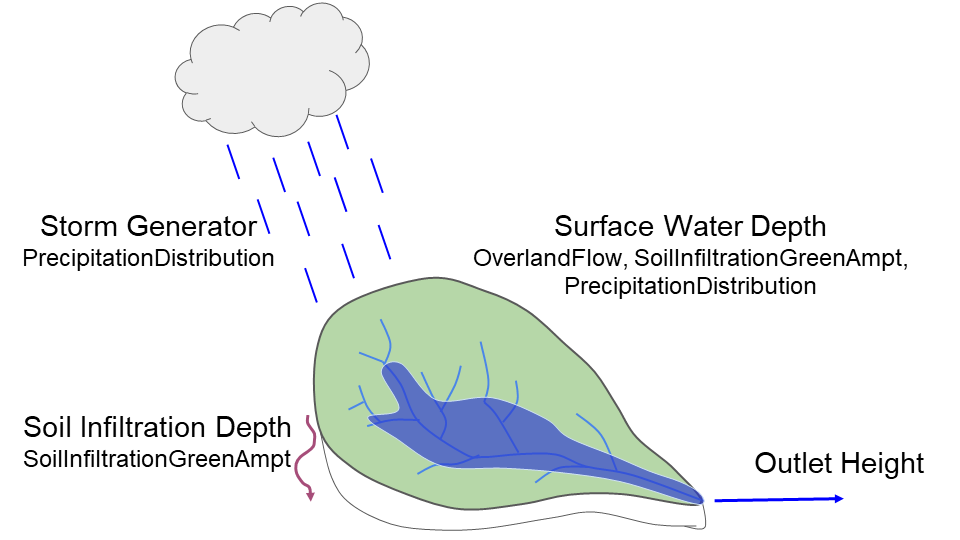


#### Step 1
Using the `PrecipitationDistribution` component in Landlab we will generate a single storm that is uniform in space, but varies in rainfall flux over the duration of the storm. This will be done on a simple catchment (`hugo_site.asc`). Rainfall flux will contribute to `surface_water_depth` which will be fed into `soil_water_infiltration__depth`.

#### Step 2
With the `SoilInfiltrationGreenAmpt`, we will calculate the `soil_water_infiltration__depth` and the new `surface_water__depth`. 

#### Step 3
This `surface_water__depth` term is also used in `OverlandFlow`! So now we can run the `OverlandFlow` to determine where (and how much) the water goes. 



### First, we import what we need

In [52]:
import numpy as np
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import OverlandFlow
import matplotlib.pyplot as plt
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components.uniform_precip import PrecipitationDistribution
import random

### Then set up for the model run

Q1 - How does different rainfall events regulates depth of the water front entering the soil during a storm ?

--> change the parameters of the rainfall generator to observe how the duration of the storm, and the intensity impacts 
- the `soil_water_infiltration__depth`, which is the front of water entering the soil.
- the `surface_water__depth`, which is the water height flowing on the surface.

In [53]:
#Create the grid using topographique value from an asci file.
fname = 'hugo_site.asc'
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED

#Define the parameter for rainfall generator
mean_duration = 2 #hours
mean_inter_duration = 10 #(h)
mean_storm_depth = 0.5 #(m) mean water heig
total_time  = 20 #(h)
delta_t = 1; # 
np.random.seed(np.arange(10)) #make sure that we are making the same random sequence everytime

#Generate the storm
precip = PrecipitationDistribution(mg, mean_storm_duration=mean_duration, mean_interstorm_duration=mean_inter_duration, mean_storm_depth=mean_storm_depth, total_t=total_time,delta_t=delta_t)
n = 5 #seed number, a certain seed gives a specific storm for the chosen parameters ##random.randint(1,101) #random number for stochastic results.
precip.seed_generator(seedval=n) #

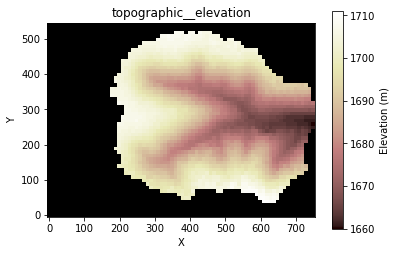

In [54]:
#Show elevation
imshow_grid_at_node(mg,
                    values = 'topographic__elevation',
                    plot_name = 'Hugo site - topographic elevation',
                    var_name = 'Elevation (m)')


## Define parameters for the infiltration component

Q2 - How does the soil hydraulic conductivity impact stream discharge?

--> change the hydraulic conductivity between 1e-5 and 1e-7, and look at how it impacts the stream discharge.
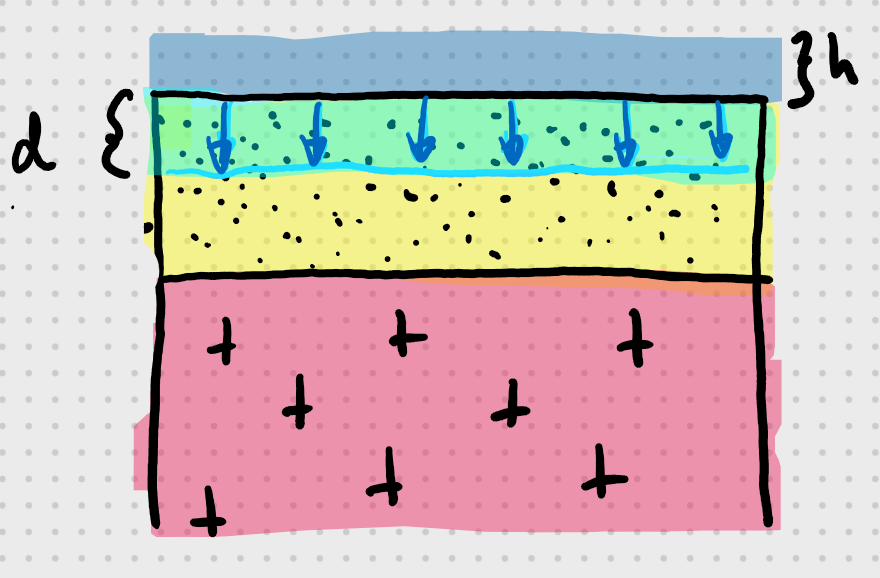

In [55]:
hydraulic_conductivity = mg.ones('node')*1e-6 #<<-- change this parameter to create more soil infiltration
h = mg.add_ones("surface_water__depth", at="node")
mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
h *= 0.01
d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d *= 0.2

In [56]:
SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=hydraulic_conductivity,soil_type='clay')
of = OverlandFlow(mg, steep_slopes=True)

### Loop through time

In [57]:

## Arrays for saving the outputs.
interstorm_dts = []
intensities = []
storm_dts = []
rain_vec = []

## Saving initial conditions
mean_SID_Times = [0]
mean_SID = [d[1]] 
outlet_depth = [h[1]]
outlet_times = [0]
rain_vec = [0]
total_elapsed_time = 0.




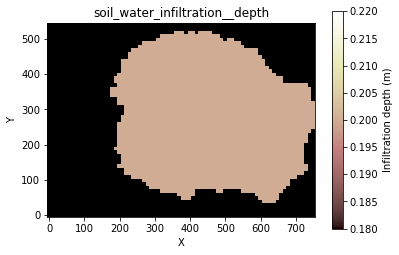

In [58]:
#Show final infiltration depth on grid
imshow_grid_at_node(mg,
                    values = 'soil_water_infiltration__depth',
                    plot_name = 'Infiltration depth',
                    var_name = 'Infiltration depth (m)')



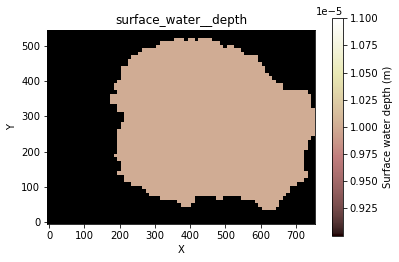

In [59]:
#Show final surface water depth on grid
imshow_grid_at_node(mg,
                    values = 'surface_water__depth',
                    plot_name = 'Initial Surface water depth',
                    var_name = 'Surface water depth (m)')

In [60]:
storm_counter = 1
for (storm_t, interstorm_dt) in precip.yield_storms():
    print('Storm #'+str(storm_counter)+  ' is running')
    node_of_max_q = 2126
    total_storm_time = (storm_t+interstorm_dt)*60*60  # in sec.
    storm_elapsed_time = 0.
    while storm_elapsed_time < total_storm_time: # in sec
        dt = 60*30 # == 10 min in sec
        total_elapsed_time += dt ## All storm counter
        storm_elapsed_time += dt
        print(storm_elapsed_time)
        if storm_elapsed_time <= storm_t * 3600: ## During storm
            mg.at_node['surface_water__depth'] += (mg.at_grid['rainfall__flux'] / 3600)*dt
            SI.run_one_step(dt=dt)
            of.run_one_step(dt=dt)
            outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
            outlet_times.append(total_elapsed_time)
            rain_vec.append(mg.at_grid['rainfall__flux'])
        else: # Interstorm time
            mg.at_node['soil_water_infiltration__depth'] -=  0.001#mg.at_node['soil_water_infiltration__depth']*(1-0.5)**(dt/(60))
            of.run_one_step(dt=dt)
            outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
            outlet_times.append(total_elapsed_time)
            rain_vec.append(0)
            
    ## End of storm simulation
    mean_SID.append(np.mean(mg.at_node['soil_water_infiltration__depth']))    
    mean_SID_Times.append(total_elapsed_time)
 
    ## Saving rainfall 
    storm_dts.append(storm_t)
    interstorm_dts.append(interstorm_dt)
    intensities.append(mg.at_grid['rainfall__flux']) ## mm/minute
    storm_counter +=1

Storm #1 is running
1800.0
3600.0
5400.0
7200.0
9000.0
10800.0
12600.0
14400.0
16200.0
18000.0
19800.0
21600.0
23400.0
25200.0
27000.0
28800.0
30600.0
32400.0
34200.0
36000.0
37800.0
39600.0
41400.0
43200.0
45000.0
46800.0
48600.0
50400.0
52200.0
54000.0
55800.0
Storm #2 is running
1800.0
3600.0
5400.0
7200.0
9000.0
10800.0
12600.0
14400.0
16200.0
18000.0


Text(0.5, 1.0, 'Final infiltration depth')

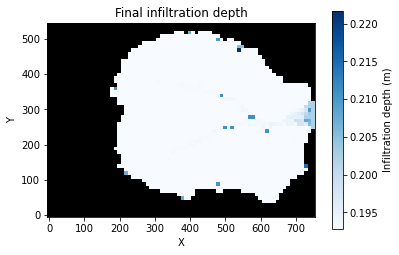

In [61]:
#Show final infiltration depth on grid
imshow_grid_at_node(mg,
                    values = 'soil_water_infiltration__depth',
                    plot_name = 'Infiltration depth',
                    var_name = 'Infiltration depth (m)',cmap ='Blues')

plt.title('Final infiltration depth')

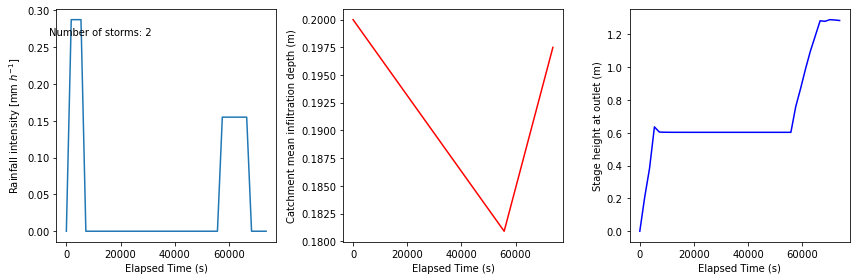

In [62]:
#Create 3 subplots to visualize:
#1. precipitation intensity (m/s) vs. time (s)
#2. catchment mean infiltration depth (m) vs. time (s)
#3. stage height at outlet (m) vs. time (s)


#initialize figure
fig, ax = plt.subplots(1,3, figsize = (12,4))

#subplot 0 - precip intensity vs time

##!!!!!!!!!!! Need a variable called rainfall_rate to be included in loop (similar to outlet depth)

rainfall_rate = np.zeros_like(np.asarray(outlet_depth)) + 5 #FAKE FOR NOW

#ax[0].plot(np.asanyarray(rain_sequence)*60) ## In mm/h
ax[0].plot(outlet_times,rain_vec)
ax[0].set_xlabel('Elapsed Time (s)')
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$')
ax[0].text(0.2, 0.9,'Number of storms: ' + number_of_storms, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
## 

#subplot 1 - catchment mean infiltration depth vs time


ax[1].plot(mean_SID_Times,mean_SID, color = 'r')
ax[1].set_xlabel('Elapsed Time (s)')
ax[1].set_ylabel('Catchment mean infiltration depth (m)')



#subplot 2 - stage height at outlet vs time

ax[2].plot(outlet_times, outlet_depth, color = 'b')
ax[2].set_xlabel('Elapsed Time (s)')
ax[2].set_ylabel('Stage height at outlet (m)')

fig.tight_layout()


In [51]:
## OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD ##


# ## Plotting rainfall data
# number_of_storms = str(len(storm_dts))  
# ## This is ugly but just for now:    
# storm_dts = np.asanyarray(storm_dts)
# interstorm_dts = np.asanyarray(interstorm_dts)
# intensities = np.asanyarray(intensities)
# time_vec  =[]
# rain_vec = []
# ## Building a  time-series rainfall vector for the total month.
# rain_sequence = []
# for i in range(0,len(storm_dts)):
#     storm = np.ones(int(np.round(storm_dts[i])))*intensities[i]
#     rain_sequence.extend(storm)
#     interstorm = np.ones(int(np.round(interstorm_dts[i])))*0
#     rain_sequence.extend(interstorm)
    

# ## Plotting the full rainfall series
# figure ,ax = plt.subplots()
# plt.plot(np.asanyarray(rain_sequence)*60) ## In mm/h 
# plt.xlabel('Time')
# plt.ylabel('Rainfall intensity [mm $h^{-1}]$')
# plt.text(0.2, 0.9,'Number of storms: ' + number_of_storms, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# ## 

[]


In [63]:
# for (storm_t, interstorm_dt) in precip.yield_storms():
    
#     node_of_max_q = 2126
#     total_mins_to_plot = 60  # in minutes.
#     plot_interval_mins = 10  
#     min_tstep_val = 1.  # necessary to get the model going cleanly
#     outlet_depth = [] 
#     outlet_times = []
#     storm_elapsed_time = 0
#     total_elapsed_time = 0
#     last_storm_loop_tracker = 0
    
#     while total_elapsed_time < total_mins_to_plot * 60:
#         dt = of.calc_time_step()
#         remaining_total_time = total_mins_to_plot * 60 - total_elapsed_time
#         if storm_elapsed_time < storm_t * 3600:
#             remaining_storm_time = storm_t * 3600 - storm_elapsed_time
#             dt = min((dt, remaining_total_time, remaining_storm_time, min_tstep_val))
#         else:
#             dt = min((dt, remaining_total_time, min_tstep_val))
#         of.run_one_step(dt=dt)
#         SI.run_one_step(dt=dt) 
#         total_elapsed_time += dt
#         storm_elapsed_time += dt
#         storm_loop_tracker = total_elapsed_time % (plot_interval_mins * 60)
        
#         if storm_loop_tracker < last_storm_loop_tracker:
#             plt.figure()
#             imshow_grid_at_node(
#                 mg,
#                 'surface_water__depth',
#                 var_name='Stage (m)',cmap ='Blues')
#             plt.title('Stage at t=' + str(total_elapsed_time//1) + 's')
#             plt.show()
#         last_storm_loop_tracker = storm_loop_tracker
#         outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
#         outlet_times.append(total_elapsed_time)
#         if storm_elapsed_time < storm_t * 3600:
#             mg.at_node['surface_water__depth'] += mg.at_grid['rainfall__flux'] * dt / 3600
